# Programming assignment 10: Image Captioning with hybrid CNN-RNN Neural Network

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# 1. Setting up the project

***

## 1.1. Import librairies

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
download_utils.link_all_keras_resources()

In [3]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras, keras.layers as L
import keras.backend as K
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os

Using TensorFlow backend.


## 1.2. Coursera token
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [4]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [49]:
# token expires every 30 min
COURSERA_TOKEN = 'd1u7PGpl8RLu3Bw5'
COURSERA_EMAIL = 'sjd1882@gmail.com'

## 1.3. Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [6]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# 2. Preparing features for CNN-RNN hybrid model

***

## 2.1. Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [7]:
IMG_SIZE = 299

In [8]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(0)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.engine.training.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
K.clear_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [9]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [10]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

## 2.2. Extract captions for images

In [11]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


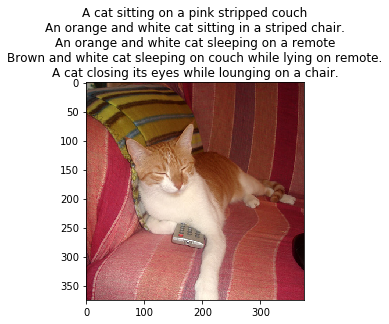

In [12]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

## 2.3. Prepare captions for training

#### Examples

In [13]:
# preview captions data
train_captions[10:12]

[['The person is holding a cell phone in their hands.',
  'A girl is using her cell phone with both hands.',
  'A person that is on their cell phone.',
  'A woman holding a smart phone wearing bracelets.',
  'A girl in a blue shirt and blue shorts holding a purple cell phone. '],
 ['There is an orange peel on the shores of a beach.',
  'An orange object sits on the beach with the ocean nearby.  ',
  'We are looking at a sea shore on a cloudy day.',
  'There is an orange peel on the beach.',
  'Two random objects are sitting on the beach. ',
  'A orange that is cut sitting in the sand.']]

#### Split sentence

In [14]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

In [15]:
train_captions[0][0]

'A long dirt road going through a forest.'

#### Generate vocabulary

In [16]:
from collections import Counter

In [17]:
def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    sentences = []

    for caption in train_captions:
        for sentence in caption:
            sentences.append(sentence)

    splited_sentences = []

    for sentence in sentences:
        splited_sentences.append(split_sentence(sentence))

    flattened_list = [y for x in splited_sentences for y in x]

    from collections import Counter

    A = Counter(flattened_list)
    my_dict = [word for word, A in A.items() if A>=5]

    for i in [PAD, UNK, START, END]:
        my_dict.append(i)
    
    return {token: index for index, token in enumerate(sorted(my_dict))}

#### Caption tokens to indices

In [18]:
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    
    all_captions = []
    
    for caption in captions:
        
        temp_caption = []
        
        for sentence in caption:
            
            temp_sentence = []
            temp_sentence.append(vocab[START]) # START tag
            
            for token in split_sentence(sentence):
                
                if token in vocab:
                    temp_sentence.append(vocab[token])
                else:
                    temp_sentence.append(vocab[UNK])
                
            temp_sentence.append(vocab[END]) # END tag
        
            temp_caption.append(temp_sentence)
        
        all_captions.append(temp_caption)
        
    return all_captions

#### Submit results

In [19]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [20]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [21]:
len(train_captions)

82783

In [22]:
train_captions[11000]

['Large amount of odd and colorful things floating down a river.',
 'A row of small decorated floats on the water',
 'Many small boats in the water by some trees.',
 'Children rides sitting in the water by trees.',
 'Colorful boats are sitting on the water near a dock.']

In [23]:
train_captions_indexed[11000]

[[2, 4244, 235, 5127, 5125, 249, 1650, 7828, 3015, 2414, 54, 6323, 0],
 [2, 54, 6398, 5127, 7009, 2153, 3016, 5155, 7804, 8486, 0],
 [2, 4585, 7009, 850, 3885, 7804, 8486, 1124, 7105, 8052, 0],
 [2, 1435, 6303, 6888, 3885, 7804, 8486, 1124, 8052, 0],
 [2, 1650, 850, 330, 6888, 5155, 7804, 8486, 4975, 54, 2357, 0]]

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an euqal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [24]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    nb_row = len(batch_captions)
    
    if max_len == None:
        nb_col = max(map(len, batch_captions))
    else:
        nb_col = min(max(map(len, batch_captions)), max_len)
    
    mat = np.zeros((nb_row, nb_col)) + pad_idx
    #print(mat.shape)
    
    for i in range(nb_row):
        if len(batch_captions[i]) <= nb_col:
            mat[i,:len(batch_captions[i])] = batch_captions[i]
        else:
            mat[i,:] = batch_captions[i][:nb_col]
    
    return mat

In [25]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [27]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# 3. Training CNN-RNN hybrid model

## 3.1. Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [28]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [37]:
# remember to reset your graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

In [38]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [39]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [40]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [42]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## 3.2. Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [43]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [44]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    # Batch image embeddings
    nb_embeddings = len(images_embeddings)
    batch_idx = np.random.choice(nb_embeddings, batch_size, replace=False)
    batch_image_embeddings = images_embeddings[batch_idx]
    
    # Batch caption matrix
    batch_captions = []
    for caption in indexed_captions[batch_idx]:
        batch_captions.append(caption[np.random.randint(5)])
    
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [45]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [46]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
# saver.restore(s, os.path.abspath("weights"))

Look at the training and validation loss, they should be decreasing!

In [47]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")


Epoch: 0, train loss: 4.3490372581481935, val loss: 3.866340646743774

Epoch: 1, train loss: 3.5659966740608215, val loss: 3.265443754196167

Epoch: 2, train loss: 3.108388129234314, val loss: 3.011701829433441

Epoch: 3, train loss: 2.8954813318252564, val loss: 2.885612602233887

Epoch: 4, train loss: 2.792999554634094, val loss: 2.815435042381287

Epoch: 5, train loss: 2.724349531173706, val loss: 2.7499422287940978

Epoch: 6, train loss: 2.6628898544311523, val loss: 2.7172711634635927

Epoch: 7, train loss: 2.6202719457149506, val loss: 2.6866603231430055

Epoch: 8, train loss: 2.58749915266037, val loss: 2.6334640431404113

Epoch: 9, train loss: 2.551788826227188, val loss: 2.6365523862838747

Epoch: 10, train loss: 2.523505685567856, val loss: 2.6176441287994385

Epoch: 11, train loss: 2.503231892824173, val loss: 2.609065821170807
Finished!


In [48]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

In [50]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [51]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.5534
Accuracy: 0.496062992126
Example 0
Predicted: a group and a in a in a #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man pouring wine from #UNK# for patrons #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man riding to on #UNK# with on #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man tries out a bicycle powered blender #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted

In [52]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

'/home/jovyan/work/week6/weights'

# 4. (Peer-reviewed section) Applying model on real-life images

## 4.1. Final model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [53]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [None], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /home/jovyan/work/week6/weights


In [54]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.999999999796 2.03703597592e-10 1.26765059997e-70 with temperature 0.01
0.903037043325 0.0969628642039 9.24709932365e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.353447726392 0.345648113606 0.300904160002 with temperature 10
0.335367280481 0.334619764349 0.33001295517 with temperature 100


In [55]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

## 4.2. First predictions

a street sign on a pole with a street sign


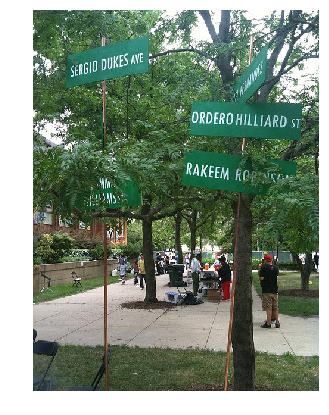

In [59]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=10)

a young boy is holding a baby in a room


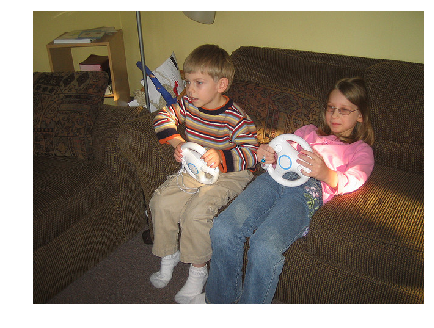

a man in a blue shirt and white shorts playing tennis


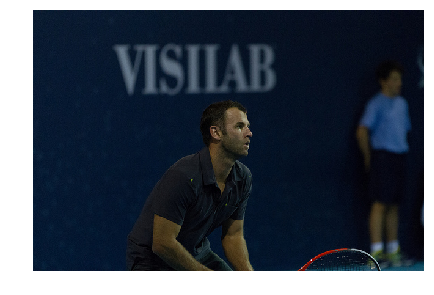

a man holding a banana in a bowl


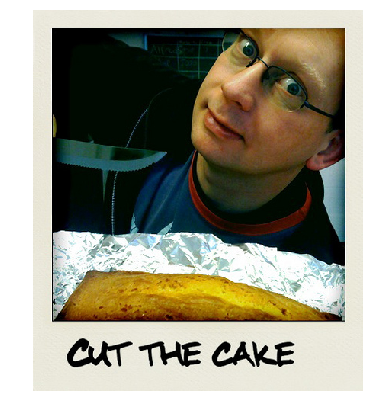

a man walking down a street holding a cell phone


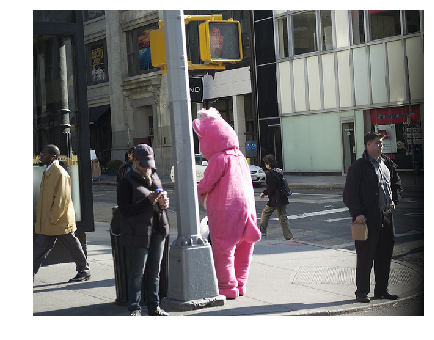

a man in a black shirt and a white bird on a boat


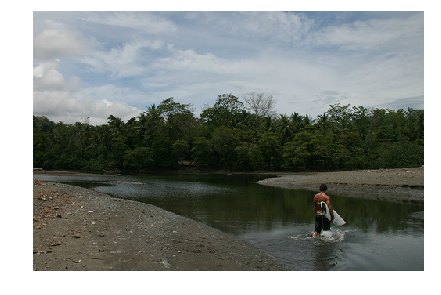

a clock tower with a clock on the side of it


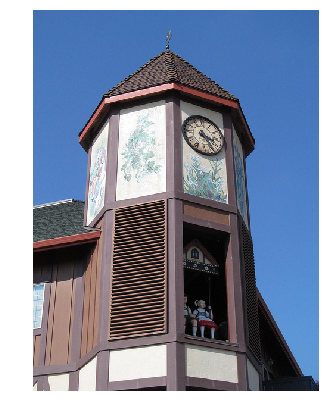

a plane sitting on the tarmac at an airport


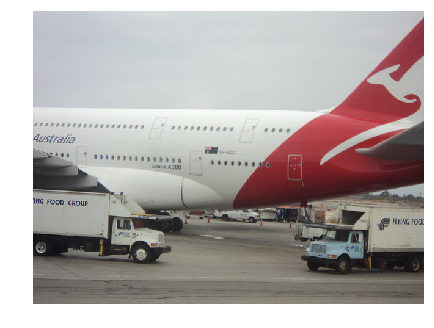

a young girl holding a remote in a room


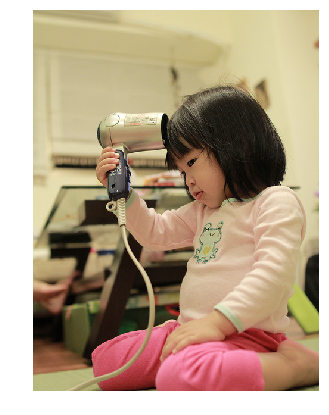

a woman holding a sandwich in a kitchen


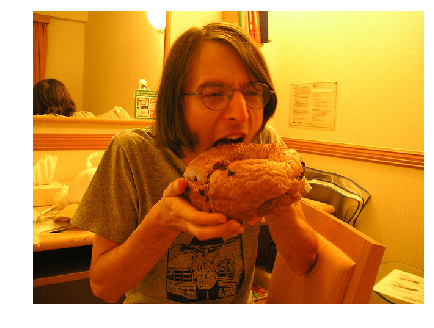

a plane sitting on a tarmac with a plane on the side


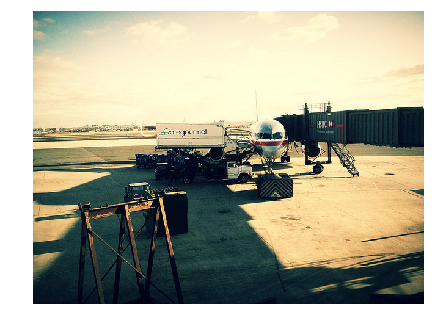

In [60]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [61]:
download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

a cake with a fork and a fork on a plate


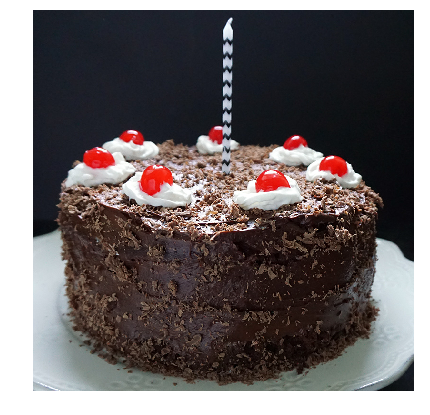

In [62]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

**The cake is a lie !**

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

## 4.2. Examples where the model (kinda) works

### 4.2.1. "*a man in a red shirt is playing soccer*"

--2018-07-08 14:51:05--  https://www.khaosod.co.th/wp-content/uploads/2017/03/river.jpg
Resolving www.khaosod.co.th (www.khaosod.co.th)... 27.254.93.164, 27.254.93.171, 27.254.93.172, ...
Connecting to www.khaosod.co.th (www.khaosod.co.th)|27.254.93.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179425 (175K) [image/jpeg]
Saving to: ‘river.jpg.1’

river.jpg.1         100%[=====================>] 175.22K   181KB/s   in 1.0s   

2018-07-08 14:51:07 (181 KB/s) - ‘river.jpg.1’ saved [179425/179425]

a man in a red shirt is playing soccer


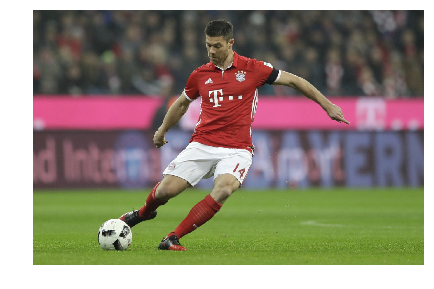

In [71]:
! wget https://www.khaosod.co.th/wp-content/uploads/2017/03/river.jpg
apply_model_to_image_raw_bytes(open("river.jpg", "rb").read())

### 4.2.2. "*a plane flying in the air with a sky background*"

--2018-07-08 14:53:43--  https://cdn-images-1.medium.com/max/1600/1*FG4i5rWK6GttYwl4GcZFXA.jpeg
Resolving cdn-images-1.medium.com (cdn-images-1.medium.com)... 104.16.121.145, 104.16.117.145, 104.16.118.145, ...
Connecting to cdn-images-1.medium.com (cdn-images-1.medium.com)|104.16.121.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305558 (298K) [image/jpeg]
Saving to: ‘1*FG4i5rWK6GttYwl4GcZFXA.jpeg.3’

1*FG4i5rWK6GttYwl4G 100%[=====================>] 298.40K  --.-KB/s   in 0.01s  

2018-07-08 14:53:43 (24.0 MB/s) - ‘1*FG4i5rWK6GttYwl4GcZFXA.jpeg.3’ saved [305558/305558]

a plane flying in the air with a sky background


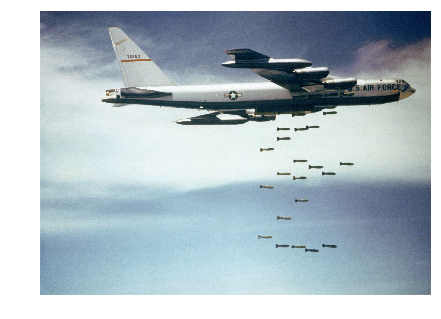

In [75]:
! wget https://cdn-images-1.medium.com/max/1600/1*FG4i5rWK6GttYwl4GcZFXA.jpeg
apply_model_to_image_raw_bytes(open("1*FG4i5rWK6GttYwl4GcZFXA.jpeg", "rb").read())

### 4.2.3. "*a man in a suit and tie standing next to a man*"

--2018-07-08 15:19:56--  http://www.findingdulcinea.com/docroot/dulcinea/fd_images/news/on-this-day/Feb/On-this-Day--Nixon-Leaves-on-Diplomatic-Trip-to-China/news/0/image.jpg
Resolving www.findingdulcinea.com (www.findingdulcinea.com)... 64.34.95.105
Connecting to www.findingdulcinea.com (www.findingdulcinea.com)|64.34.95.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95232 (93K) [image/jpeg]
Saving to: ‘image.jpg.2’

image.jpg.2         100%[=====================>]  93.00K  --.-KB/s   in 0.02s  

2018-07-08 15:19:57 (3.99 MB/s) - ‘image.jpg.2’ saved [95232/95232]

a man in a suit and tie standing next to a man


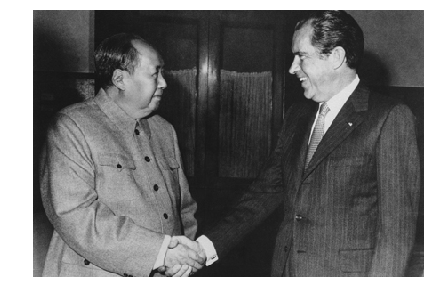

In [92]:
! wget http://www.findingdulcinea.com/docroot/dulcinea/fd_images/news/on-this-day/Feb/On-this-Day--Nixon-Leaves-on-Diplomatic-Trip-to-China/news/0/image.jpg
apply_model_to_image_raw_bytes(open("image.jpg", "rb").read())

### 4.2.4. "*a plane sitting on a runway with a sky background*"

--2018-07-08 16:21:31--  https://upload.wikimedia.org/wikipedia/commons/a/aa/Defense.gov_News_Photo_110920-N-VN693-049_-_Sailors_prepare_an_F_A-18C_Hornet_for_flight_operations_aboard_the_aircraft_carrier_USS_John_C._Stennis_CVN_74_as_the_ship_operates_in_the_5th_Fleet.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203007 (198K) [image/jpeg]
Saving to: ‘Defense.gov_News_Photo_110920-N-VN693-049_-_Sailors_prepare_an_F_A-18C_Hornet_for_flight_operations_aboard_the_aircraft_carrier_USS_John_C._Stennis_CVN_74_as_the_ship_operates_in_the_5th_Fleet.jpg’

Defense.gov_News_Ph 100%[=====================>] 198.25K  --.-KB/s   in 0.002s 

2018-07-08 16:21:31 (88.6 MB/s) - ‘Defense.gov_News_Photo_110920-N-VN693-049_-_Sailors_prepare_an_F_A-18C_Hornet_for_flight_operations_aboard_the_aircraft_carrier_USS

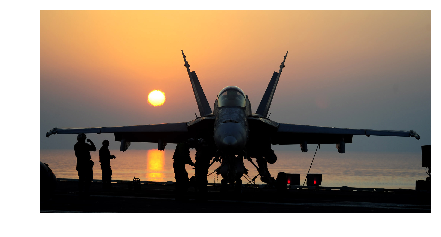

In [145]:
! wget https://upload.wikimedia.org/wikipedia/commons/a/aa/Defense.gov_News_Photo_110920-N-VN693-049_-_Sailors_prepare_an_F_A-18C_Hornet_for_flight_operations_aboard_the_aircraft_carrier_USS_John_C._Stennis_CVN_74_as_the_ship_operates_in_the_5th_Fleet.jpg
apply_model_to_image_raw_bytes(open("Defense.gov_News_Photo_110920-N-VN693-049_-_Sailors_prepare_an_F_A-18C_Hornet_for_flight_operations_aboard_the_aircraft_carrier_USS_John_C._Stennis_CVN_74_as_the_ship_operates_in_the_5th_Fleet.jpg", "rb").read())

### 4.2.5. "*a bird is standing on a rock in the wild*"

--2018-07-08 16:26:18--  http://static.sites.yp.com/var/m_3/35/356/11189690/1373218-eagle.jpg
Resolving static.sites.yp.com (static.sites.yp.com)... 208.93.105.36
Connecting to static.sites.yp.com (static.sites.yp.com)|208.93.105.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162462 (159K) [image/jpeg]
Saving to: ‘1373218-eagle.jpg’

1373218-eagle.jpg   100%[=====================>] 158.65K  --.-KB/s   in 0.008s 

2018-07-08 16:26:18 (18.5 MB/s) - ‘1373218-eagle.jpg’ saved [162462/162462]

a bird is standing on a rock in the wild


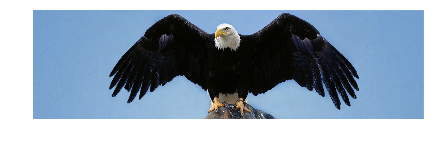

In [149]:
! wget http://static.sites.yp.com/var/m_3/35/356/11189690/1373218-eagle.jpg
apply_model_to_image_raw_bytes(open("1373218-eagle.jpg", "rb").read())

### 4.2.6. "*a glass of wine sitting on a table next to a glass of wine*"

--2018-07-08 16:30:39--  https://static.shoplightspeed.com/shops/610486/files/007106580/600x600x2/set-of-4-red-wine-glasses-by-mann.jpg
Resolving static.shoplightspeed.com (static.shoplightspeed.com)... 34.234.63.112
Connecting to static.shoplightspeed.com (static.shoplightspeed.com)|34.234.63.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27804 (27K) [image/jpeg]
Saving to: ‘set-of-4-red-wine-glasses-by-mann.jpg.1’

set-of-4-red-wine-g 100%[=====================>]  27.15K  --.-KB/s   in 0s     

2018-07-08 16:30:39 (144 MB/s) - ‘set-of-4-red-wine-glasses-by-mann.jpg.1’ saved [27804/27804]

a glass of wine sitting on a table next to a glass of wine


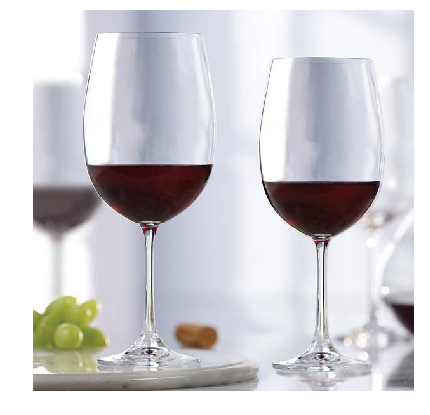

In [154]:
! wget https://static.shoplightspeed.com/shops/610486/files/007106580/600x600x2/set-of-4-red-wine-glasses-by-mann.jpg
apply_model_to_image_raw_bytes(open("set-of-4-red-wine-glasses-by-mann.jpg", "rb").read())

### 4.2.7. "*a train that is sitting on the tracks*"

--2018-07-08 16:33:36--  https://static.ladepeche.fr/content/media/image/large/2018/02/03/201802031781-full.jpg
Resolving static.ladepeche.fr (static.ladepeche.fr)... 212.95.70.227
Connecting to static.ladepeche.fr (static.ladepeche.fr)|212.95.70.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64514 (63K) [image/jpeg]
Saving to: ‘201802031781-full.jpg.2’

201802031781-full.j 100%[=====================>]  63.00K   341KB/s   in 0.2s   

2018-07-08 16:33:37 (341 KB/s) - ‘201802031781-full.jpg.2’ saved [64514/64514]

a train that is sitting on the tracks


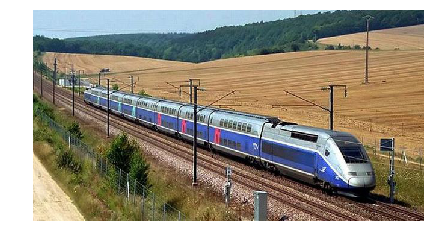

In [159]:
! wget https://static.ladepeche.fr/content/media/image/large/2018/02/03/201802031781-full.jpg
apply_model_to_image_raw_bytes(open("201802031781-full.jpg", "rb").read())

### 4.2.8. "*a person on a surfboard riding a wave*"

--2018-07-08 16:36:46--  https://www.disruptsports.com/wp-content/uploads/2016/01/688415-south-west-monster-surf.jpg
Resolving www.disruptsports.com (www.disruptsports.com)... 104.28.13.134, 104.28.12.134, 2400:cb00:2048:1::681c:c86, ...
Connecting to www.disruptsports.com (www.disruptsports.com)|104.28.13.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35334 (35K) [image/jpeg]
Saving to: ‘688415-south-west-monster-surf.jpg’

688415-south-west-m 100%[=====================>]  34.51K  --.-KB/s   in 0s     

2018-07-08 16:36:48 (97.6 MB/s) - ‘688415-south-west-monster-surf.jpg’ saved [35334/35334]

a person on a surfboard riding a wave


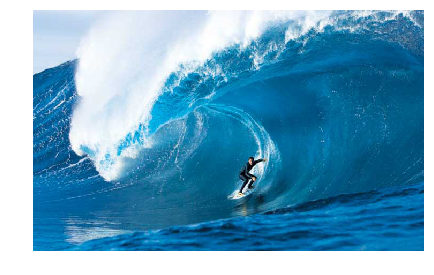

In [163]:
! wget https://www.disruptsports.com/wp-content/uploads/2016/01/688415-south-west-monster-surf.jpg
apply_model_to_image_raw_bytes(open("688415-south-west-monster-surf.jpg", "rb").read())

### 4.2.9. "*a baseball player swinging a bat at a ball*"

--2018-07-08 16:46:56--  https://s.marketwatch.com/public/resources/images/MW-DU117_david__ZH_20150913112300.jpg
Resolving s.marketwatch.com (s.marketwatch.com)... 23.46.56.204, 2600:1408:20:48e::7e5, 2600:1408:20:490::7e5
Connecting to s.marketwatch.com (s.marketwatch.com)|23.46.56.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159463 (156K) [image/jpeg]
Saving to: ‘MW-DU117_david__ZH_20150913112300.jpg.1’

MW-DU117_david__ZH_ 100%[=====================>] 155.73K  --.-KB/s   in 0.002s 

2018-07-08 16:46:56 (72.1 MB/s) - ‘MW-DU117_david__ZH_20150913112300.jpg.1’ saved [159463/159463]

a baseball player swinging a bat at a ball


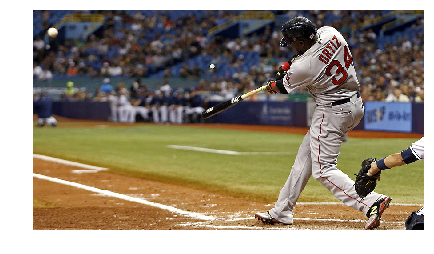

In [178]:
! wget https://s.marketwatch.com/public/resources/images/MW-DU117_david__ZH_20150913112300.jpg
apply_model_to_image_raw_bytes(open("MW-DU117_david__ZH_20150913112300.jpg", "rb").read())

### 4.2.10. "*a tennis player is playing tennis on a court*"

--2018-07-08 16:50:28--  https://cdn.cnn.com/cnnnext/dam/assets/180702140425-roger-federer-wimbledon-statistics-exlarge-169.jpg
Resolving cdn.cnn.com (cdn.cnn.com)... 104.96.237.38, 2600:1408:2000:18a::3134, 2600:1408:2000:1a3::3134
Connecting to cdn.cnn.com (cdn.cnn.com)|104.96.237.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57223 (56K) [image/jpeg]
Saving to: ‘180702140425-roger-federer-wimbledon-statistics-exlarge-169.jpg’

180702140425-roger- 100%[=====================>]  55.88K  --.-KB/s   in 0s     

2018-07-08 16:50:28 (220 MB/s) - ‘180702140425-roger-federer-wimbledon-statistics-exlarge-169.jpg’ saved [57223/57223]

a tennis player is playing tennis on a court


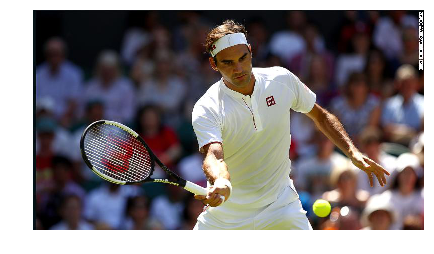

In [179]:
! wget https://cdn.cnn.com/cnnnext/dam/assets/180702140425-roger-federer-wimbledon-statistics-exlarge-169.jpg
apply_model_to_image_raw_bytes(open("180702140425-roger-federer-wimbledon-statistics-exlarge-169.jpg", "rb").read())

## 4.3. Examples where the models fails (spectacularly) !

--2018-07-08 15:41:30--  https://www.chathamhouse.org/sites/default/files/styles/main_image_800x460/public/field/field_image_main/Lewis_4.jpg
Resolving www.chathamhouse.org (www.chathamhouse.org)... 52.17.176.171, 52.49.159.196
Connecting to www.chathamhouse.org (www.chathamhouse.org)|52.17.176.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41836 (41K) [image/jpeg]
Saving to: ‘Lewis_4.jpg.2’

Lewis_4.jpg.2       100%[=====================>]  40.86K  --.-KB/s   in 0s     

2018-07-08 15:41:31 (252 MB/s) - ‘Lewis_4.jpg.2’ saved [41836/41836]

a black and white photo of a black and white photo of a steam engine


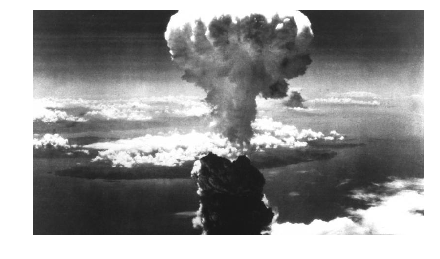

In [117]:
! wget https://www.chathamhouse.org/sites/default/files/styles/main_image_800x460/public/field/field_image_main/Lewis_4.jpg
apply_model_to_image_raw_bytes(open("Lewis_4.jpg", "rb").read())

### 4.3.2. "*a man sitting on a bench with a surfboard*"

--2018-07-08 15:25:26--  http://scd.rfi.fr/sites/filesrfi/imagecache/rfi_16x9_1024_578/sites/images.rfi.fr/files/aef_image/000_WAS2004050505268_0.jpg
Resolving scd.rfi.fr (scd.rfi.fr)... 104.96.220.176, 104.96.220.163
Connecting to scd.rfi.fr (scd.rfi.fr)|104.96.220.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78817 (77K) [image/jpeg]
Saving to: ‘000_WAS2004050505268_0.jpg.4’

000_WAS200405050526 100%[=====================>]  76.97K  --.-KB/s   in 0s     

2018-07-08 15:25:26 (210 MB/s) - ‘000_WAS2004050505268_0.jpg.4’ saved [78817/78817]

a man sitting on a bench with a surfboard


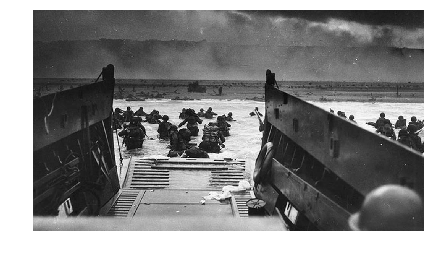

In [97]:
! wget http://scd.rfi.fr/sites/filesrfi/imagecache/rfi_16x9_1024_578/sites/images.rfi.fr/files/aef_image/000_WAS2004050505268_0.jpg
apply_model_to_image_raw_bytes(open("000_WAS2004050505268_0.jpg", "rb").read())

### 4.3.3. "*a group of people standing around a large body of water*"

--2018-07-08 16:35:38--  https://upload.wikimedia.org/wikipedia/commons/7/77/My_Lai_massacre.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 310083 (303K) [image/jpeg]
Saving to: ‘My_Lai_massacre.jpg’

My_Lai_massacre.jpg 100%[=====================>] 302.82K  --.-KB/s   in 0.004s 

2018-07-08 16:35:38 (67.5 MB/s) - ‘My_Lai_massacre.jpg’ saved [310083/310083]

a group of people standing around a large body of water


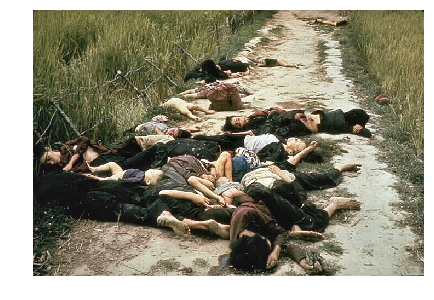

In [161]:
! wget https://upload.wikimedia.org/wikipedia/commons/7/77/My_Lai_massacre.jpg
apply_model_to_image_raw_bytes(open("My_Lai_massacre.jpg", "rb").read())

### 4.3.4. "*a dog is riding a wave in the ocean*"

--2018-07-08 15:21:39--  https://i.ytimg.com/vi/Qzxy3GtSzt0/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 172.217.7.246, 172.217.15.86, 172.217.15.118, ...
Connecting to i.ytimg.com (i.ytimg.com)|172.217.7.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115212 (113K) [image/jpeg]
Saving to: ‘maxresdefault.jpg’

maxresdefault.jpg   100%[=====================>] 112.51K  --.-KB/s   in 0.002s 

2018-07-08 15:21:39 (60.1 MB/s) - ‘maxresdefault.jpg’ saved [115212/115212]

a dog is riding a wave in the ocean


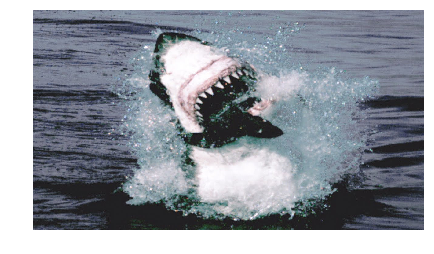

In [93]:
! wget https://i.ytimg.com/vi/Qzxy3GtSzt0/maxresdefault.jpg
apply_model_to_image_raw_bytes(open("maxresdefault.jpg", "rb").read())

### 4.3.5. "*a man and woman are sitting on a couch*"

--2018-07-08 15:10:35--  https://mediadc.brightspotcdn.com/dims4/default/7083d2a/2147483647/strip/true/crop/2290x1322+0+0/resize/2290x1322!/quality/90/?url=https%3A%2F%2Fmediadc.brightspotcdn.com%2F23%2F55%2F4422262e1661d3ac22e55f1f217b%2F87ec8573ead2af3aeea6b22fa234be28.jpg
Resolving mediadc.brightspotcdn.com (mediadc.brightspotcdn.com)... 52.84.122.146, 52.84.122.232, 52.84.122.88, ...
Connecting to mediadc.brightspotcdn.com (mediadc.brightspotcdn.com)|52.84.122.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555704 (543K) [image/jpeg]
Saving to: ‘index.html?url=https%3A%2F%2Fmediadc.brightspotcdn.com%2F23%2F55%2F4422262e1661d3ac22e55f1f217b%2F87ec8573ead2af3aeea6b22fa234be28.jpg.2’

index.html?url=http 100%[=====================>] 542.68K  --.-KB/s   in 0.008s 

2018-07-08 15:10:35 (64.4 MB/s) - ‘index.html?url=https%3A%2F%2Fmediadc.brightspotcdn.com%2F23%2F55%2F4422262e1661d3ac22e55f1f217b%2F87ec8573ead2af3aeea6b22fa234be28.jpg.2’ saved [555704/555704]

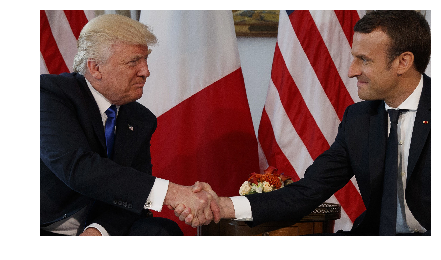

In [89]:
! wget https://mediadc.brightspotcdn.com/dims4/default/7083d2a/2147483647/strip/true/crop/2290x1322+0+0/resize/2290x1322!/quality/90/?url=https%3A%2F%2Fmediadc.brightspotcdn.com%2F23%2F55%2F4422262e1661d3ac22e55f1f217b%2F87ec8573ead2af3aeea6b22fa234be28.jpg
apply_model_to_image_raw_bytes(open("index.html?url=https%3A%2F%2Fmediadc.brightspotcdn.com%2F23%2F55%2F4422262e1661d3ac22e55f1f217b%2F87ec8573ead2af3aeea6b22fa234be28.jpg", "rb").read())

### 4.3.6. "*a plate of food with a sandwich and a salad*"

--2018-07-08 15:41:37--  https://media.blueapron.com/recipes/2121/c_main_dish_images/1490637097-4-0002-2195/403_2PRE07-steak-frites-18311_WEB_Center_high_feature.jpg
Resolving media.blueapron.com (media.blueapron.com)... 151.101.34.133
Connecting to media.blueapron.com (media.blueapron.com)|151.101.34.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142683 (139K) [image/jpeg]
Saving to: ‘403_2PRE07-steak-frites-18311_WEB_Center_high_feature.jpg.3’

403_2PRE07-steak-fr 100%[=====================>] 139.34K  --.-KB/s   in 0.005s 

2018-07-08 15:41:37 (25.9 MB/s) - ‘403_2PRE07-steak-frites-18311_WEB_Center_high_feature.jpg.3’ saved [142683/142683]

a plate of food with a sandwich and a salad


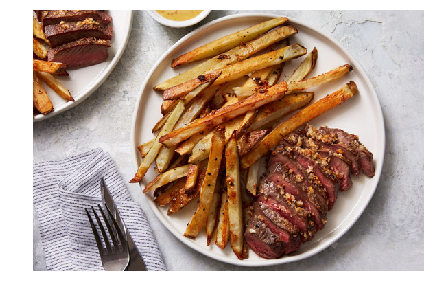

In [118]:
! wget https://media.blueapron.com/recipes/2121/c_main_dish_images/1490637097-4-0002-2195/403_2PRE07-steak-frites-18311_WEB_Center_high_feature.jpg
apply_model_to_image_raw_bytes(open("403_2PRE07-steak-frites-18311_WEB_Center_high_feature.jpg", "rb").read())

### 4.3.7. "*a train is coming down the tracks in a field*"

--2018-07-08 15:48:29--  https://s.abcnews.com/images/US/branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg
Resolving s.abcnews.com (s.abcnews.com)... 23.72.80.9
Connecting to s.abcnews.com (s.abcnews.com)|23.72.80.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77688 (76K) [image/jpeg]
Saving to: ‘branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg.1’

branch-davidian-fir 100%[=====================>]  75.87K  --.-KB/s   in 0.04s  

2018-07-08 15:48:29 (1.89 MB/s) - ‘branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg.1’ saved [77688/77688]

a train is coming down the tracks in a field


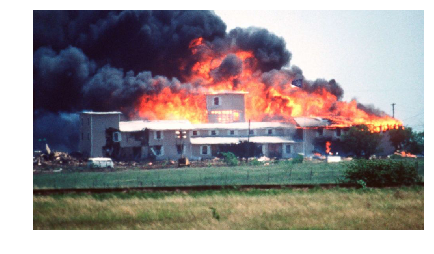

In [121]:
! wget https://s.abcnews.com/images/US/branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg
apply_model_to_image_raw_bytes(open("branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg", "rb").read())

### 4.3.8. "*a baseball player holding a baseball bat on a field*"

--2018-07-08 15:55:32--  https://abrilveja.files.wordpress.com/2017/12/pixaccca7ao-paris-maio1968.jpg
Resolving abrilveja.files.wordpress.com (abrilveja.files.wordpress.com)... 192.0.72.2
Connecting to abrilveja.files.wordpress.com (abrilveja.files.wordpress.com)|192.0.72.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1161877 (1.1M) [image/jpeg]
Saving to: ‘pixaccca7ao-paris-maio1968.jpg’

pixaccca7ao-paris-m 100%[=====================>]   1.11M  --.-KB/s   in 0.01s  

2018-07-08 15:55:32 (105 MB/s) - ‘pixaccca7ao-paris-maio1968.jpg’ saved [1161877/1161877]

a baseball player holding a baseball bat on a field


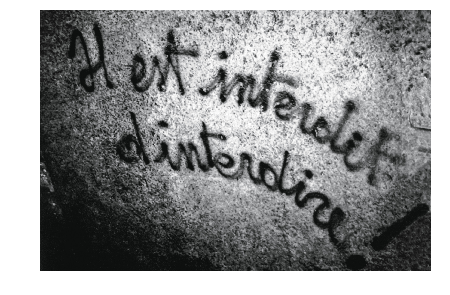

In [125]:
! wget https://abrilveja.files.wordpress.com/2017/12/pixaccca7ao-paris-maio1968.jpg
apply_model_to_image_raw_bytes(open("pixaccca7ao-paris-maio1968.jpg", "rb").read())

### 4.3.9. "*a man in a hat and tie standing next to a skateboard*"

--2018-07-08 16:10:46--  https://www.culturecreature.com/wp-content/uploads/2016/08/nine-inch-nails-woodstock-94-2-650x418.jpg
Resolving www.culturecreature.com (www.culturecreature.com)... 132.148.208.216
Connecting to www.culturecreature.com (www.culturecreature.com)|132.148.208.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55197 (54K) [image/jpeg]
Saving to: ‘nine-inch-nails-woodstock-94-2-650x418.jpg’

nine-inch-nails-woo 100%[=====================>]  53.90K  --.-KB/s   in 0.08s  

2018-07-08 16:10:46 (637 KB/s) - ‘nine-inch-nails-woodstock-94-2-650x418.jpg’ saved [55197/55197]

a man in a hat and tie standing next to a skateboard


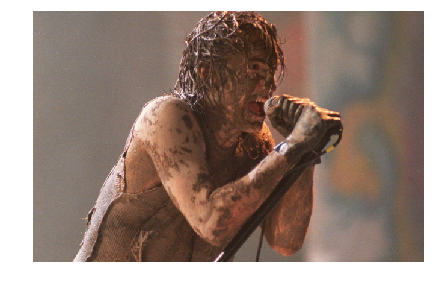

In [136]:
! wget https://www.culturecreature.com/wp-content/uploads/2016/08/nine-inch-nails-woodstock-94-2-650x418.jpg
apply_model_to_image_raw_bytes(open("nine-inch-nails-woodstock-94-2-650x418.jpg", "rb").read())

### 4.3.10. "*a man sitting on a bench with a cell phone*"

--2018-07-08 16:04:35--  https://vignette.wikia.nocookie.net/cnc/images/7/78/Yuri_and_Stalin.png/revision/latest?cb=20120226185151
Resolving vignette.wikia.nocookie.net (vignette.wikia.nocookie.net)... 74.120.184.194, 74.120.184.204
Connecting to vignette.wikia.nocookie.net (vignette.wikia.nocookie.net)|74.120.184.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129014 (126K) [image/png]
Saving to: ‘latest?cb=20120226185151.1’

latest?cb=201202261 100%[=====================>] 125.99K  --.-KB/s   in 0.002s 

2018-07-08 16:04:36 (80.2 MB/s) - ‘latest?cb=20120226185151.1’ saved [129014/129014]

a man sitting on a bench with a cell phone


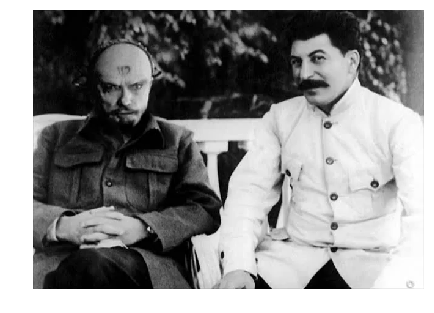

In [130]:
! wget https://vignette.wikia.nocookie.net/cnc/images/7/78/Yuri_and_Stalin.png/revision/latest?cb=20120226185151
apply_model_to_image_raw_bytes(open('latest?cb=20120226185151', "rb").read())

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!